# Mechanism vs Traditional Regime

The goal here is to show that the system is better and fairer under mechanism-implemented game, than the traditional regime

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import math
import random
import itertools
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, defaultdict
from pandas.plotting import parallel_coordinates
# from PSSimPy.simulator import ABMSim
from PSSimPy import Bank, Account
from PSSimPy.credit_facilities import AbstractCreditFacility
from PSSimPy.utils import add_minutes_to_time, minutes_between

from MDP import MechMDPSearch, MDPStateExt, TradMDPSearch, MDPStateTrad
from SimClasses import ABMSim

## Setup

In [3]:
class SimpleCollateralized(AbstractCreditFacility):
    
    def __init__(self, gamma: float) -> None:
        super().__init__()
        self.gamma = gamma  # marginal cost of borrowing

    def calculate_fee(self, amount: float) -> float:
        return amount * self.gamma

    def lend_credit(self, account: Account, amount: float) -> float:
        if amount > account.posted_collateral:
            return 0.0
        self.used_credit.setdefault(account.id, []).append(amount)
        account.balance += amount
        account.posted_collateral -= amount
        return amount

    def collect_repayment(self, account: Account) -> None:
        repaid = []
        for i, amount in enumerate(self.used_credit.get(account.id, [])):
            if amount <= account.balance:
                account.balance -= amount
                account.posted_collateral += amount
                repaid.append(i)

        # Remove repaid credit entries
        self.used_credit[account.id] = [
            amt for idx, amt in enumerate(self.used_credit[account.id]) if idx not in repaid
        ]


In [4]:
class CollateralizedCreditFacility(AbstractCreditFacility):
    def __init__(self, collateralized_transactions=None, gamma=0.6, phi=0.5, chi=0.75):
        AbstractCreditFacility.__init__(self)
        self.collateralized_transactions = collateralized_transactions if collateralized_transactions is not None else {}
        self.gamma = gamma  # traditional borrowing cost
        self.phi = phi      # pledged-collateral borrowing cost
        self.chi = chi      # unsecured borrowing cost
        # Track credit issued: account.id -> list of tuples (credit_type, amount)
        self.used_credit = {}
        self.history = {}

    def lend_credit(self, account, amount: float) -> None:
        """
        Issue credit to *account* for *amount* according to the rules below.
        ──────────────────────────────────────────────────────────────────────────
        γ  : marginal cost of credit secured by posted collateral
        φ  : marginal cost of credit secured by incoming transactions
        χ  : marginal cost of unsecured credit

        1. If χ is the lowest of {γ, φ, χ}: lend the full *amount* unsecured.

        2. If account.posted_collateral ≥ amount (i.e. collateral is sufficient):
        2a. If φ < χ, first exhaust every valid incoming transaction (status_code
            == 0 and not yet pledged) as collateral, looping until either no
            valid txns remain or credit need is met.
        2b. Use posted collateral for any remainder (or the whole amount if
            φ ≥ χ).

        3. If account.posted_collateral < amount (i.e. collateral is insufficient):
        3a. If χ < φ, lend the full *amount* unsecured.
        3b. Else, first exhaust valid incoming transactions as collateral.
            If credit is still needed, lend the balance unsecured.

        Every tranche advanced is logged in
        self.used_credit[account.id]  →  List[Tuple[str, float, *extra*]]
        so later cost calculations can distinguish ‘unsecured’,
        ‘collateralized_txn’, and ‘collateralized_posted’.
        ──────────────────────────────────────────────────────────────────────────
        """

        # ────────────────────── internal helpers ──────────────────────────
        def _record(kind: str, qty: float, ref=None):
            self.used_credit.setdefault(account.id, []).append((kind, qty, ref))

        def _issue_unsecured(qty: float) -> float:
            if qty > 0:
                account.balance += qty
                _record("unsecured", qty)
            return 0.0

        def _use_posted_collateral(qty: float) -> float:
            take = min(qty, account.posted_collateral)
            if take > 0:
                account.posted_collateral -= take
                account.balance += take
                _record("collateralized_posted", take)
            return qty - take

        def _use_incoming_txn_collateral(qty: float) -> float:
            if qty <= 0:
                return 0.0
            # all un‑pledged, settled‑status incoming txns, largest first
            valid = [
                t for t in account.txn_in
                if t.status_code == 0
                and t not in self.collateralized_transactions.get(account.id, set())
            ]
            valid.sort(key=lambda t: t.amount, reverse=True)

            for txn in valid:
                if qty == 0:
                    break
                take = min(qty, txn.amount)
                self.collateralized_transactions.setdefault(account.id, set()).add(txn)
                account.balance += take
                _record("collateralized_txn", take, txn)
                qty -= take
            return qty
        # ────────────────── end helpers ───────────────────────────────

        remaining = amount

        # Rule 1 ─ unsecured is globally cheapest
        if self.chi < self.gamma and self.chi < self.phi:
            _issue_unsecured(remaining)
            return

        # Rule 2 ─ posted collateral is at least as large as the need
        if account.posted_collateral >= remaining:
            if self.phi < self.chi:
                remaining = _use_incoming_txn_collateral(remaining)
            remaining = _use_posted_collateral(remaining)
            # The branch guarantees sufficiency, but belt‑and‑braces:
            if remaining:
                _issue_unsecured(remaining)
            return

        # Rule 3 ─ posted collateral is insufficient
        if self.chi < self.phi:
            _issue_unsecured(remaining)
            return

        # Prefer incoming‑txn collateral first, then unsecured for any leftover
        remaining = _use_incoming_txn_collateral(remaining)
        _issue_unsecured(remaining)

    def collect_all_repayment(self, day: int, accounts: List[Account]) -> None:
        """
        Collect repayments from all accounts.
        """
        for account in accounts:
            self.history.setdefault(account.id, []).append(
                (day, self.get_total_credit(account), self.get_total_fee(account))
            )
            self.collect_repayment(account)

    def calculate_fee(self, credit_amount, credit_type) -> float:
        """
        Calculate the fee for a given credit amount based on its type.
        
        - For 'collateralized_posted', fee = gamma * credit_amount.
        - For 'collateralized_txn', fee = phi * credit_amount.
        - For 'unsecured', fee = chi * credit_amount.
        """
        if credit_type == 'collateralized_posted':
            return self.gamma * credit_amount
        elif credit_type == 'collateralized_txn':
            return self.phi * credit_amount
        elif credit_type == 'unsecured':
            return self.chi * credit_amount
        else:
            return 0.0


    def collect_repayment(self, account) -> None:
        # Not implemented for now.
        pass

    def get_total_credit(self, account: Account) -> float:
        """
        Return the aggregate amount of credit issued to *account*,
        independent of credit source.  Works even if each log entry
        carries extra metadata.
        """
        return sum(entry[1] for entry in self.used_credit.get(account.id, []))

    def get_total_fee(self, account: Account) -> float:
        """
        Sum all fees owed by *account* based on the credit tranches logged
        in self.used_credit.  Works whether each log entry is
        (ctype, amount)
        or
        (ctype, amount, extra_metadata).
        """
        total_fee = 0.0
        for entry in self.used_credit.get(account.id, []):
            credit_type = entry[0]      # always first element
            amount      = entry[1]      # always second element
            total_fee  += self.calculate_fee(
                credit_amount=amount,
                credit_type=credit_type
            )
        return total_fee

    
    def get_total_credit_and_fee(self, account: Account) -> float:
        """
        Obtain the total credit and fee for an account.
        """
        return self.get_total_credit(account) + self.get_total_fee(account)

### Helper Functions

In [5]:
def calculate_delay_cost(sim_name, account: str, delta: float, delta_prime: float):
    df_processed_txns = pd.read_csv(f"{sim_name}-processed_transactions.csv")

    # Filter transactions for the given account
    relevant_txns = df_processed_txns[df_processed_txns['from_account'] == account]
    
    # Initialize total delay cost
    total_delay_cost = 0
    
    # Calculate delay cost for each transaction
    for _, row in relevant_txns.iterrows():
        # Extract submission_time and time as datetime objects
        submission_time = pd.to_datetime(row['submission_time'])
        txn_time = pd.to_datetime(row['time'])
        
        # Calculate the delay in minutes (convert Timedelta to minutes)
        delay_minutes = (submission_time - txn_time).total_seconds() / 60
        
        # Calculate the delay cost
        delay_cost = (delay_minutes / 15) * (delta + delta_prime)
        
        # Accumulate the delay cost
        total_delay_cost += delay_cost
    
    return total_delay_cost

In [6]:
def calculate_borrowing_cost(sim_name, account: str):
    df_credit_facility = pd.read_csv(f'{sim_name}-credit_facility.csv')
    
    # Filter for the given account
    relevant_credit = df_credit_facility[df_credit_facility['account'] == account]

    # Initialize total borrowing cost
    total_borrowing_cost = 0

    # Calculate borrowing cost at each period
    for _, row in relevant_credit.iterrows():
        borrowing_cost = row['total_fee']
        total_borrowing_cost += borrowing_cost
    
    return total_borrowing_cost

## Simulation

### Simulation Logic

In [7]:
def simulate_game(p_t: float, delta: float, gamma: float, delta_prime: float, phi: float, chi: float, seed: int):
    mdp = MechMDPSearch(
        n_players=10,
        n_periods=10,
        p_t=p_t,
        delta=delta,
        delta_prime=delta_prime,
        gamma=gamma,
        phi=phi,
        chi=chi,
        seed=seed
    )

    # Set up strategic bank agent
    class MechStrategicBank(Bank):
        def __init__(self, name, strategy_type='MechStrategic', **kwargs):
            super().__init__(name, strategy_type, **kwargs)
            self.mdp_state = mdp.initial_state() # mdp needs to be redefined before each simulation run
            self.mdp_previous_action = 0
            self.n_periods = 10
        
        # overwrite strategy
        def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
            if len(txns_to_settle) == 0:
                return set()
            else:
                # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
                txn = txns_to_settle.copy().pop()
                bank_account = txn.sender_account

            # calculate amount of obligations that arrived in this period
            arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])
            # calculate the amount of claims that arrived in this current period
            observed_claims = sum([txn.amount for txn in all_outstanding_transactions if txn.arrival_time == current_time and txn.recipient_account.owner == self.name])

            if current_time == "08:00":
                partial_obs = {
                    "inbound_payments": 0,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)
            else:
                # calculate actual inbound payments from previous period
                previous_time = add_minutes_to_time(current_time, -15)
                df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
                filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                        (df_processed_txns['settlement_time'] == previous_time)]
                inbound_payments = filtered_df['amount'].sum()

                partial_obs = {
                    "inbound_payments": inbound_payments,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

            _, best_act = mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
            self.n_periods -= 1
            self.mdp_previous_action = best_act

            if best_act == 1:
                return txns_to_settle
            else:
                return set()

    trad_mdp = TradMDPSearch(
        n_players=10,
        n_periods=10,
        p_t=p_t,
        delta=delta,
        gamma=gamma,
        seed=seed
    )
    class TradStrategicBank(Bank):
        def __init__(self, name, strategy_type='TradStrategic', **kwargs):
            super().__init__(name, strategy_type, **kwargs)
            self.mdp_state = trad_mdp.initial_state() # mdp needs to be redefined before each simulation run
            self.mdp_previous_action = 0
            self.n_periods = 10
        
        # overwrite strategy
        def strategy(self, txns_to_settle: set, all_outstanding_transactions: set, sim_name: str, day: int, current_time: str, queue) -> set:
            if len(txns_to_settle) == 0:
                return set()
            else:
                # we assume 1:1 mapping of bank to account so we can just extract any txn and use that account
                txn = txns_to_settle.copy().pop()
                bank_account = txn.sender_account

            # calculate amount of obligations that arrived in this period
            arrived_obligations = sum([txn.amount for txn in txns_to_settle if txn.arrival_time == current_time])
            # calculate the amount of claims that arrived in this current period
            observed_claims = sum([txn.amount for txn in all_outstanding_transactions if txn.arrival_time == current_time and txn.recipient_account.owner == self.name])

            if current_time == "08:00":
                partial_obs = {
                    "inbound_payments": 0,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = trad_mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)
            else:
                # calculate actual inbound payments from previous period
                previous_time = add_minutes_to_time(current_time, -15)
                df_processed_txns = pd.read_csv(f'{sim_name}-processed_transactions.csv')
                filtered_df = df_processed_txns[(df_processed_txns['to_account'] == bank_account) & 
                        (df_processed_txns['settlement_time'] == previous_time)]
                inbound_payments = filtered_df['amount'].sum()

                partial_obs = {
                    "inbound_payments": inbound_payments,
                    "arrived_obligations": arrived_obligations,
                    "observed_claims": observed_claims,
                    "observed_expected": 0.75  # not used when ζ = 0
                }

                self.mdp_state = trad_mdp.update_current_state(self.mdp_state, self.mdp_previous_action, partial_obs)

            _, best_act = trad_mdp.depth_limited_value(self.mdp_state, depth=self.n_periods)
            self.n_periods -= 1
            self.mdp_previous_action = best_act

            if best_act == 1:
                return txns_to_settle
            else:
                return set()
    
    total_costs = {'mech': 0, 'trad': 0}

    # simulation with mechanism
    strategy_mapping = {'Strategic': MechStrategicBank}
    collateralized_credit_facility = CollateralizedCreditFacility(gamma=gamma, phi=phi, chi=chi)
    banks = pd.read_csv('data_input/bank_template_with_mech_strategy_all10.csv')
    accounts = pd.read_csv('data_input/account_template_mix_collateral.csv')
    mech_sim_name = 'mech_sim'
    mech_sim = ABMSim(name=mech_sim_name, banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=collateralized_credit_facility, open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=p_t, txn_amount_range=(1,1))
    mech_sim.run()  
    # extract costs
    # delay_costs = {}
    # borrowing_costs = {}
    for account in accounts['id'].tolist():
        # delay_costs[account] = calculate_delay_cost(sim_name, account, delta, delta_prime)
        # borrowing_costs[account] = calculate_borrowing_cost(sim_name, account)
        total_costs['mech'] += (calculate_delay_cost(mech_sim_name, account, delta, delta_prime) + calculate_borrowing_cost(mech_sim_name, account))

    # simulation without mechanism
    strategy_mapping = {'Strategic': TradStrategicBank}
    banks = pd.read_csv('data_input/bank_template_with_mech_strategy_all10.csv')
    accounts = pd.read_csv('data_input/account_template_mix_collateral.csv')
    trad_sim_name = 'trad_sim'
    trad_sim = ABMSim(name=trad_sim_name, banks=banks, accounts=accounts, strategy_mapping=strategy_mapping, credit_facility=SimpleCollateralized(gamma=gamma), open_time='08:00', close_time='10:30', eod_force_settlement=True, txn_arrival_prob=p_t, txn_amount_range=(1,1))
    trad_sim.run()
    for account in accounts['id'].tolist():
        total_costs['trad'] += (calculate_delay_cost(trad_sim_name, account, delta, 0) + calculate_borrowing_cost(trad_sim_name, account))

    # tear down
    # Remove each .csv file
    csv_files = glob.glob("*.csv")
    for file in csv_files:
        os.remove(file)

    return total_costs

### Simulation runs

/tmp/ipykernel_121748/3715029845.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.02, 1, 0.95])


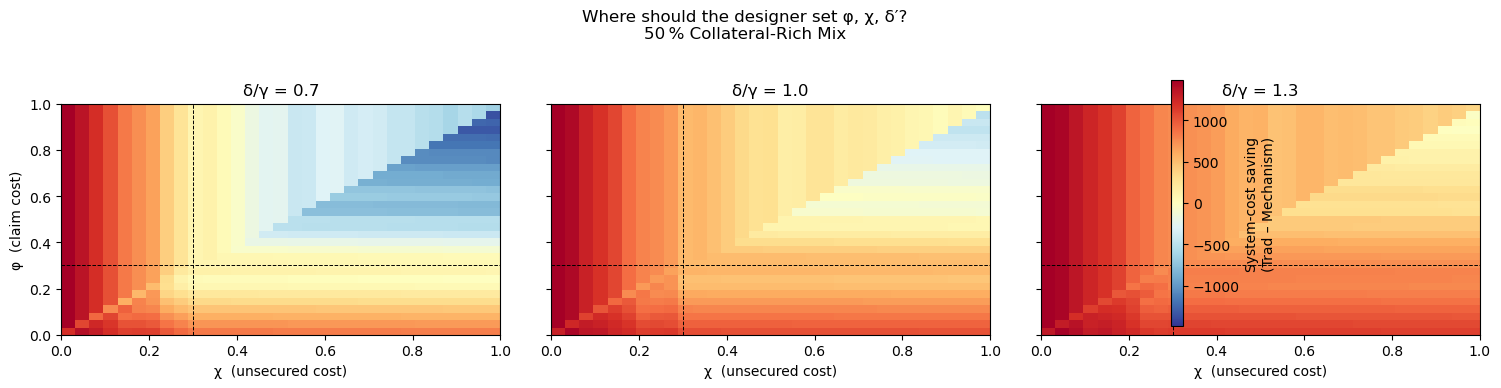

In [ ]:
# --------- uncontrollable environmental grid (three δ/γ slices) ----------
gamma = 0.3                 # pick a representative collateral cost
delta_ratios = [0.7, 1.0, 1.3]        # mild / knife‑edge / severe delay
p_t = 0.8
seed0 = 1000        # Monte‑Carlo seeds
n_seeds = 1         # small MC replications for stability

# --------- designer‑controlled sweep ----------
phi_vals = np.linspace(0.0, 1.0, 31)    # φ in [0,1]
chi_vals = np.linspace(0.0, 1.0, 31)    # χ in [0,1]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for panel, delta_ratio in enumerate(delta_ratios):
    Z = np.zeros((len(phi_vals), len(chi_vals)))
    delta = delta_ratio * gamma            # actual delay cost

    for i, phi in enumerate(phi_vals):
        for j, chi in enumerate(chi_vals):

            # ------------- designer picks δ′ at incentive‑compatibility bound
            delta_prime = max(0.0, min(max(gamma, phi), chi) - delta)

            trad_costs, mech_costs = [], []
            for k in range(n_seeds):
                res = simulate_game(
                    p_t         = p_t,
                    delta       = delta,
                    delta_prime = delta_prime,
                    gamma       = gamma,
                    phi         = phi,
                    chi         = chi,
                    seed        = seed0 + k
                )
                trad_costs.append(res['trad'])
                mech_costs.append(res['mech'])

            Z[i, j] = np.mean(trad_costs) - np.mean(mech_costs)

    # --------- plot this slice ----------
    ax = axes[panel]
    im = ax.imshow(
        Z,
        origin='lower',
        extent=[chi_vals[0], chi_vals[-1], phi_vals[0], phi_vals[-1]],
        aspect='auto',
        cmap='RdYlBu',
        vmin=-np.max(np.abs(Z)),
        vmax= np.max(np.abs(Z))
    )
    ax.set_title(f"δ/γ = {delta_ratio:.1f}")
    ax.set_xlabel("χ  (unsecured cost)")
    if panel == 0:
        ax.set_ylabel("φ  (claim cost)")
    # guide lines where φ = γ and χ = γ
    ax.axvline(x=gamma, color='k', ls='--', lw=0.7)
    ax.axhline(y=gamma, color='k', ls='--', lw=0.7)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8,
             label="System‑cost saving\n(Trad – Mechanism)")
fig.suptitle("Where should the designer set φ, χ, δ′?\n50 % Collateral‑Rich Mix")
fig.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()